In [1]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2023-02-02 03:30:10--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  21.8MB/s    in 94s     

2023-02-02 03:31:45 (20.2 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [ ]:
!tar xvf VOCtrainval_11-May-2012.tar

In [3]:
!rm VOCtrainval_11-May-2012.tar

In [4]:
'''Define a function that parses the annotations from the XML files and stores it in an array
'''
import os 
import xml.etree.cElementTree as ET
# 通过路径名构建数据集的树
def parse_annotation(ann_dir,img_dir,labels=[]):
    all_imgs = []
    seen_labels = {}
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img ={'object':[]}
        tree = ET.parse(ann_dir+ann)
        for elem in tree.iter():
            if "filename" in elem.tag:
                path_to_image = img_dir+elem.text
                img['filename'] = path_to_image
                if not os.path.exists(path_to_image):
                    assert ValueError,"file doesn't exist\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}

                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text
                        if len(labels)>0 and obj['name'] not in labels:
                            break
                        else:
                            img['object']+=[obj]
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] =  1
                        
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
                    
            if len(img['object'])>0:
                all_imgs+=[img]
    return all_imgs,seen_labels


'''Anchor box blog:https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html'''
# parse annotations
train_image_folder = "VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "VOCdevkit/VOC2012/Annotations/"

In [7]:
import numpy as np 
ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))


N train = 650910


Input
  object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
  filename: VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg
  width: 486
  height: 500
******************************
Output
          [{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}]


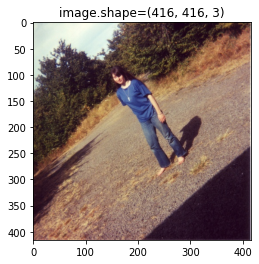

In [9]:
'''Define a ImageReader class to process an image,it takes in an image and returns 
the resized image and all the objects in the image'''
import copy 
import cv2 
import matplotlib.pyplot as plt 
class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W,norm=None):
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm = norm
    
    def encode_core(self,image,reorder_rgb = True):
        image = cv2.resize(image,(self.IMAGE_H,self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        '''read in and resize the image,annotations are resized accordingly
        Arguments:
            train_instance: dictionary containing filename,height,width and object'''
        if not isinstance(train_instance,dict):
            train_instance = {"filename":train_instance}
        
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        h,w,c = image.shape 
        if image is None:
            print("Can't find ",image_name)
        image = self.encode_core(image,reorder_rgb=True)
        if 'object' in train_instance.keys():
            all_objs = copy.deepcopy(train_instance['object'])
            # fix object's postition and size 
            for obj in all_objs:
                for attr in ['xmin','xmax']:
                    obj[attr] = int(obj[attr]*float(self.IMAGE_W)/w)
                    obj[attr] = max(min(obj[attr],self.IMAGE_W),0)
                
                for attr in ['ymin','ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H)/h)
                    obj[attr] = max(min(obj[attr],self.IMAGE_H),0)
        else:
            return image
        return image,all_objs

# sample usage of the ImageReader class 
def normalize(image):
    return image/255.

print("Input")
timage = train_image[0]
for key, v in timage.items():
    print("  {}: {}".format(key,v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print("          {}".format(all_objs))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

In [10]:

'''Define BestAnchorBoxFinder which finds the best anchor box for a particular object
This is done by finding the anchor box with the highest IOU(Intersection over Union) with the bounding box of the object.
'''
class BestAnchorBoxFinder(object):
    '''Anchors: a np.array of even number length '''
    def __init__(self,ANCHORS):
        self.anchors = [BoundBox(0,0,ANCHORS[2*i],ANCHORS[2*i+1]) for i in range(int(len(ANCHORS)//2))]

    def _interval_overlap(self,interval_a,interval_b):
        x1,x2 = interval_a
        x3,x4 = interval_b
        if x3<x1:
            if x4<x1:
                return 0 
            else:
                return min(x2,x4) - x1 
        
        else:
            if x2<x3:
                return 0 
            else:
                return min(x2,x4) - x3 
    
    def bbox_iou(self,box1,box2):
        intersect_w = self._interval_overlap([box1.xmin,box1.xmax],[box2.xmin,box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin,box1.ymax],[box2.ymin,box2.ymax])
        intersect = intersect_w*intersect_h

        w1,h1 = box1.xmax - box1.xmin,box1.ymax-box1.ymin
        w2,h2 = box2.xmax - box2.xmin,box2.ymax - box2.ymin

        union = w1*h1 + w2*h2 - intersect
        return float(intersect)/union
    
    def find(self,center_w,center_h):
        # find the anchor that best predicts this box 
        best_anchor = -1 
        max_iou = -1
        # each anchor box is specialized to have a certain shape 
        # eg:flat large rectangle or small square 
        shifted_box = BoundBox(0,0,center_w,center_h)
        # for given object,find the best anchor box 
        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            iou = self.bbox_iou(shifted_box,anchor)
            if max_iou<iou:
                best_anchor= i 
                max_iou = iou
        return (best_anchor,max_iou)


In [11]:
class BoundBox:
    def __init__(self,xmin,ymin,xmax,ymax,confidence=None,classes=None) :
        self.xmin = xmin
        self.ymin = ymin 
        self.xmax = xmax
        self.ymax = ymax
        # the code below are used during inference
        # probability
        self.confidence = confidence

        # class probabilities 
        self.set_class(classes)

    def set_class(self,classes):
        self.classes = classes
        self.label = np.argmax(self.classes)

    def get_label(self):
        return self.label
    
    def get_score(self):
        return(self.classes[self.label])


In [12]:

'''sample usage of the BESTANCHORBOXFINDER class '''
# Anchor box width and height found in https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html
_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])
print(".."*40)
print("The three example anchor boxes:")
count = 0
for i in range(0,len(_ANCHORS01),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS01[i],_ANCHORS01[i+1]))
    count += 1
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS01)

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:


In [13]:
for w in range(1,9,2):
    w /= 10.
    for h in range(1,9,2):
        h /= 10.
        best_anchor,max_iou = babf.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(
            w,h,best_anchor,max_iou))

bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3, h = 0.7) --> best anchor box index = 3, iou = 0.65
bounding box (w = 0.5, h = 0.1) --> best anchor box index = 1, iou = 0.19
bounding box (w = 0.5, h = 0.3) --> best anchor box index = 3, iou = 0.44
bounding box (w = 0.5, h = 0.5) --> best anchor box index = 3, iou = 0.70
bounding box (w = 0.5, h = 0.7) --> best anchor box index = 3, iou = 0.75
bounding box (w = 0.7, h = 0.1) --> best anchor box index = 1, iou = 0.16
bounding box (w = 0.7, h = 0.3) --> be

In [14]:
def rescale_centerxy(obj,config):
    '''
    Arguments:
        obj:        dictionary containing xmin,xmax,ymin,ymax
        config:     dictionary containing IMAGE_W,GRID_W,IMAGE_H and GRID_H
    
    '''
    center_x = 0.5*(obj['xmin'] + obj['xmax'])
    center_x = center_x/(float(config["IMAGE_W"]) / config['GRID_W'])
    center_y = 0.5*(obj['ymin'] + obj['ymax'])
    center_y = center_y/(float(config['IMAGE_H']) / config['GRID_H'])
    return (center_x,center_y)

def rescale_centerwh(obj,config):
    '''
    Arguments:
        obj:        dictionary containing xmin,xmax,ymin,ymax
        config:     dictionary containing IMAGE_W,GRID_W,IMAGE_H and GRID_H
    '''
    # unit :grid cell
    center_w = (obj['xmax'] - obj['xmin'])/(float(config['IMAGE_W'])/config['GRID_W'])
    # unit :grid cell
    center_h = (obj['ymax'] - obj['ymin'])/(float(config['IMAGE_H'])/config['GRID_H'])
    return(center_w,center_h)


In [15]:
'''sample usage'''
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}
center_x, center_y = rescale_centerxy(obj,config)
center_w, center_h = rescale_centerwh(obj,config)

print("cebter_x abd cebter_w should range between 0 and {}".format(config["GRID_W"]))
print("cebter_y abd cebter_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))



cebter_x abd cebter_w should range between 0 and 13
cebter_y abd cebter_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


In [54]:
class SimpleBatchGenerator(Sequence):
    def __init__(self,images,config,norm=None,shuffle=True):
        '''
        config : dictionary containing necessary hyper parameters for traning. e.g., 
            {
            'IMAGE_H'         : 416, 
            'IMAGE_W'         : 416,
            'GRID_H'          : 13,  
            'GRID_W'          : 13,
            'LABELS'          : ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                                  'bus',        'car',      'cat',  'chair',     'cow',
                                  'diningtable','dog',    'horse',  'motorbike', 'person',
                                  'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'],
            'ANCHORS'         : array([ 1.07709888,   1.78171903,  
                                        2.71054693,   5.12469308, 
                                        10.47181473, 10.09646365,  
                                        5.48531347,   8.11011331]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }
        
        '''

        self.config = config
        self.config['BOX'] = int(len(self.config['ANCHORS'])/2)
        self.config['CLASS']  = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.images)
        
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))
        
    def __getitem___(self,idx):
        '''
        Arguments:
            idx: non-negeative integer value 
        Returns:
            x_batch: the numpy array of shape (BATCH_SIZE,IMAGE_H,IMAGE_W,N,channels)
                        x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).

            y_batch: the numpy array of shape (BATCH_SIZE,GRID_H,GRID_W,BOX,4+1+Nclassess)
                        Box = the number of anchor boxes

                        y_batch[iframe,igird_h,igrid_w,ianchor,:4] contains a (center_x,center_y,center_w,center_h)
                        of ianchorth anchor at grid cell = (igrid_h,igrid_w) if the object exists in this (grid cell,anchor)
                        pair,else they simply contain 0 

                        y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
                        class object exists in this (grid cell, anchor) pair, else it contains 0.

            b_batch: the numpy array of shape(BATCH_SIZE,1,1,1,TRUE_BOX_BUFFER,4)
                        b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's (center_X,center_y,center_w,center_h) in iframe frame
                        If ibuffer > N objects in iframeth frame ,then the values are simply 0 
                        TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
                        biggest number of objects can also record all objects.

                        The order of the objects do not matter.

                        This is just a hack to easily calculate loss. 
        '''
        l_bound = idx*self.config['BATCH_SIZE']

        r_bound =  (idx+1)*self.config['BATCH_SIZE']

        if r_bound>len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']
        instance_count = 0 
        # prepare empty storage space will be output 
        x_batch = np.zeros((r_bound - l_bound,self.config['IMAGE_H'],self.config['IMAGE_W'],3))
        b_batch = np.zeros((r_bound - l_bound,1,1,1,self.config['TRUE_BOX_BUFFER'],4))
        # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound ,self.config['GRID_H'],self.config['GRID_W'],self.config['BOX'],4+1+len(self.config['LABELS'])))
        # desired network output 
        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size 
            img,all_objs =self.imageReader.fit(train_instance)

            # construct output from object's x,y,w,h
            true_box_index = 0 
            for obj in all_objs:
                if obj['xmax']>obj['xmin'] and obj['ymax']>obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x,center_y = rescale_centerxy(obj,self.config)

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x <self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_idx = self.config['LABELS'].index(obj['name'])
                        center_w,center_h = rescale_centerwh(obj,self.config)
                        box = [center_x,center_y,center_w,center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w,center_h)
                        # assign ground truth x,y,w,h confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such case,the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_idx] = 1 # class probability of the object

                        # assign the true box to b_batch
                        b_batch[instance_count,0,0,0,true_box_index] = box 

                        true_box_index +=1 
                        true_box_index = true_box_index%self.config['TRUE_BOX_BUFFER']
                    
            x_batch[instance_count] = img 
            # increase instance counter in current batch
            instance_count += 1
        return [x_batch,b_batch],y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images)


In [48]:
IMAGE_H, IMAGE_W = 416, 416
GRID_H,GRID_W = 13,13

ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  

BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


In [45]:
print(ANCHORS)

[ 30763.02111168  50887.67721583  77415.93086773 146366.35905788
 299085.50050353 288365.09830765 156666.03801667 231632.94624691]


In [55]:
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)
# test =train_batch_generator.test(idx=1)
[x_batch,b_batch],y_batch = train_batch_generator.__getitem___(idx=3)
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))


x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [58]:
iframe = 1 
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config['GRID_H']):
        for igrid_w in range(generator_config['GRID_W']):
            for ianchor in range(generator_config['BOX']):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] # ground truth confidence 
                if C==1:
                    class_num = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_num)==1 
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(igrid_h,igrid_w,ianchor,class_num[0]))
check_object_in_grid_anchor_pair(iframe)


igrid_h=06,igrid_w=05,iAnchor=00, chair
igrid_h=06,igrid_w=07,iAnchor=00, chair
igrid_h=07,igrid_w=02,iAnchor=00, chair
igrid_h=07,igrid_w=03,iAnchor=00, chair
igrid_h=07,igrid_w=09,iAnchor=00, chair
igrid_h=09,igrid_w=06,iAnchor=00, diningtable
igrid_h=10,igrid_w=01,iAnchor=00, chair
igrid_h=10,igrid_w=06,iAnchor=00, chair
igrid_h=10,igrid_w=08,iAnchor=00, chair


In [61]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ['W',"H"]:
        GRID_ = generator_config["GRID_"+wh]##13
        IMAGE_ = generator_config["IMAGE_"+wh]##416

        if wh =='W':
            pltax = plt.axvline
            plttick = plt.xticks
        else:
            pltax = plt.axvline
            plttick = plt.yticks

        for count in range(GRID_):
            l = IMAGE_ * count/GRID_
            pltax(l,color='yellow',alpha=0.3)
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])
  

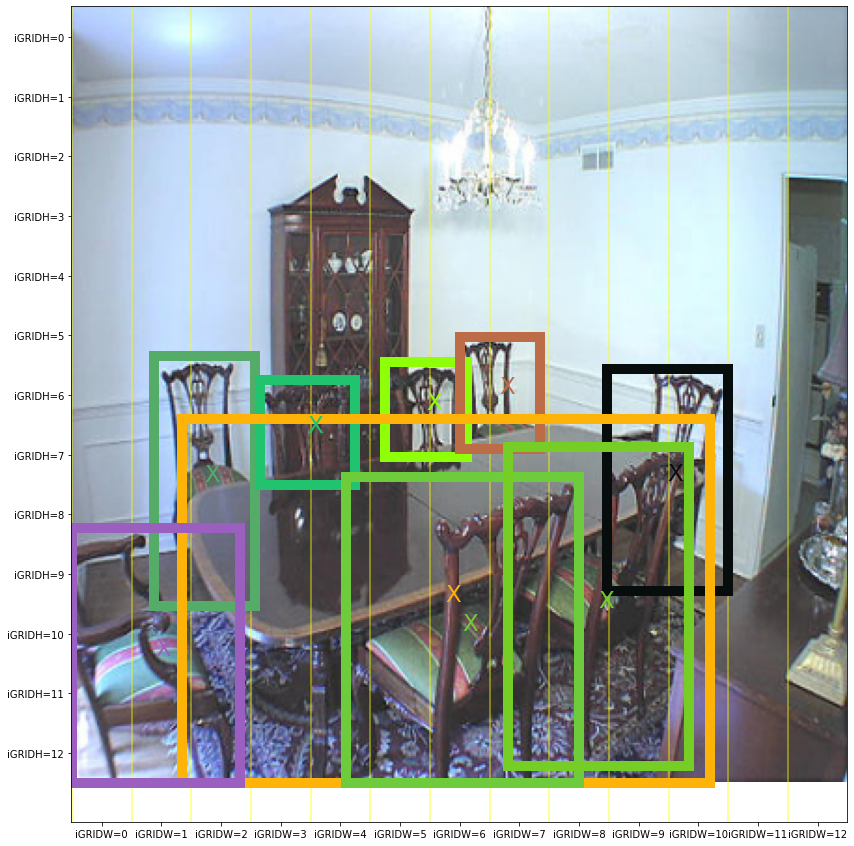

In [62]:
def plot_grid(irow):
    import seaborn as sns 
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0 
    for igrid_h in range(generator_config['GRID_H']):
        for igrid_w in range(generator_config['GRID_W']):
            for ianchor in range(generator_config['BOX']):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4]
                if C==1:
                    class_num = np.array(LABELS)[np.where(vec[5:])]
                    x,y,w,h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj +=  1 
                    xmin = x - 0.5*w 
                    ymin = y - 0.5*h 
                    xmax = x + 0.5*w 
                    ymax = y+0.5* h 
                    # center 
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)
plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

------------------------------
igrid_h=04,igrid_w=05,iAnchor=00, person
igrid_h=10,igrid_w=03,iAnchor=00, person


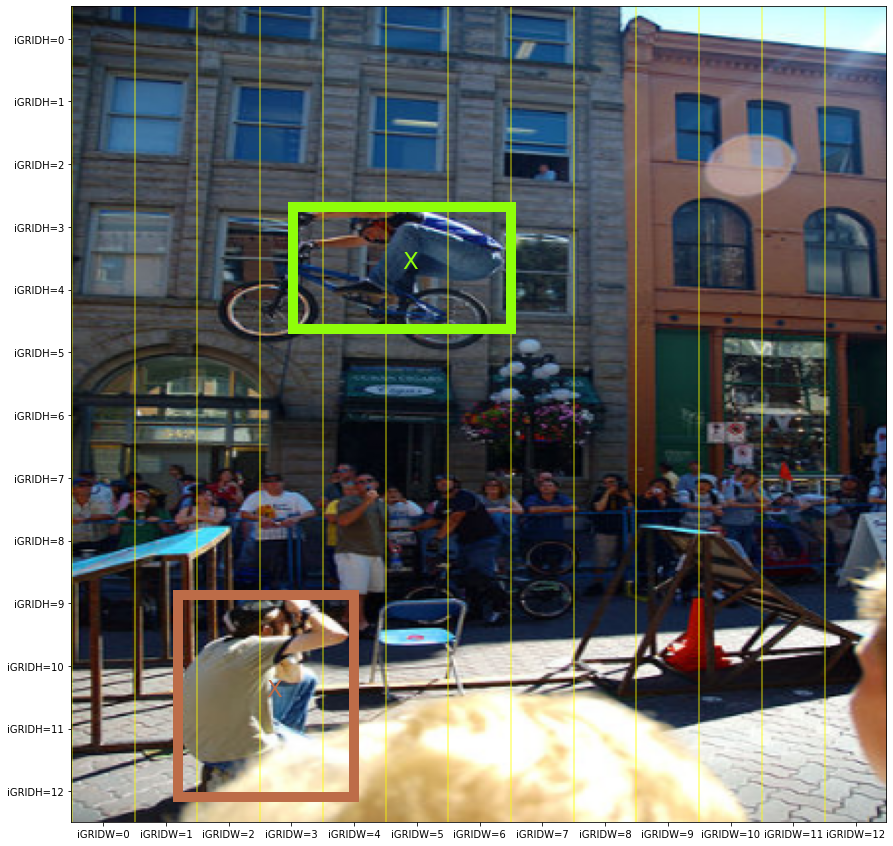

------------------------------
igrid_h=09,igrid_w=10,iAnchor=00, person


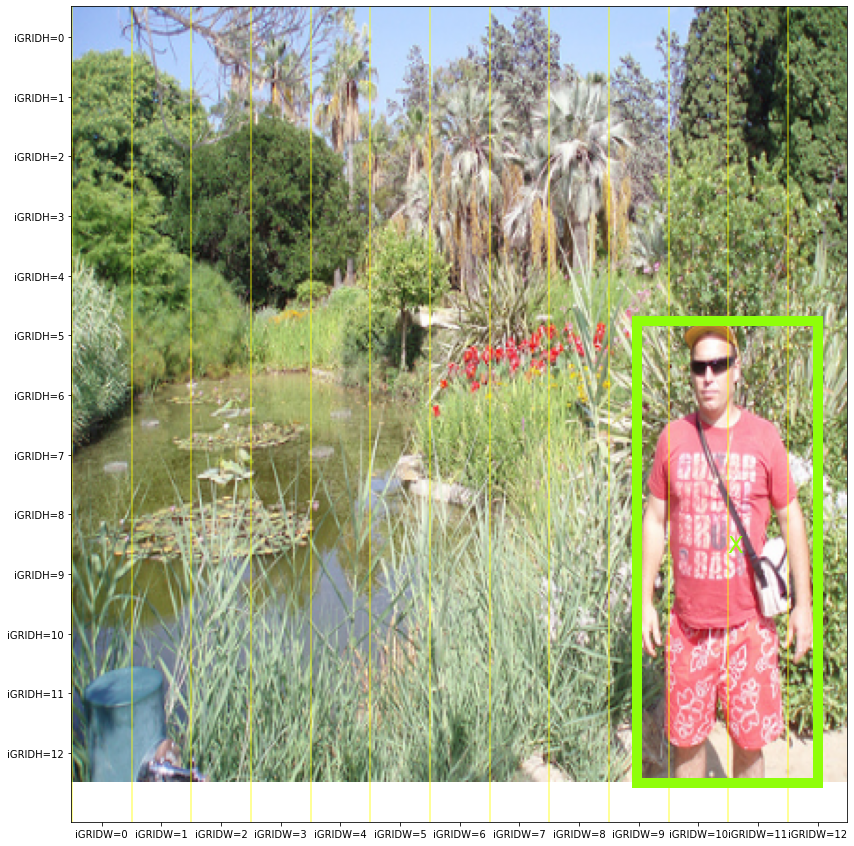

------------------------------
igrid_h=06,igrid_w=00,iAnchor=00, car
igrid_h=06,igrid_w=01,iAnchor=00, car
igrid_h=06,igrid_w=02,iAnchor=00, car
igrid_h=06,igrid_w=06,iAnchor=00, bus


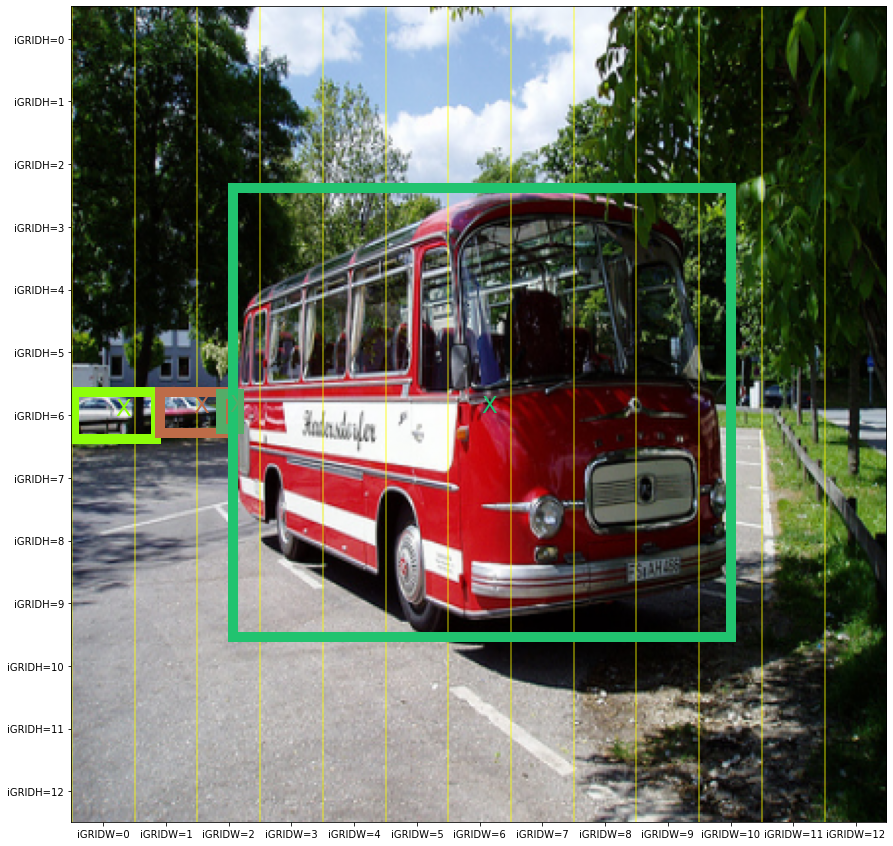

------------------------------
igrid_h=06,igrid_w=05,iAnchor=00, dog
igrid_h=06,igrid_w=06,iAnchor=00, sofa
igrid_h=09,igrid_w=10,iAnchor=00, dog


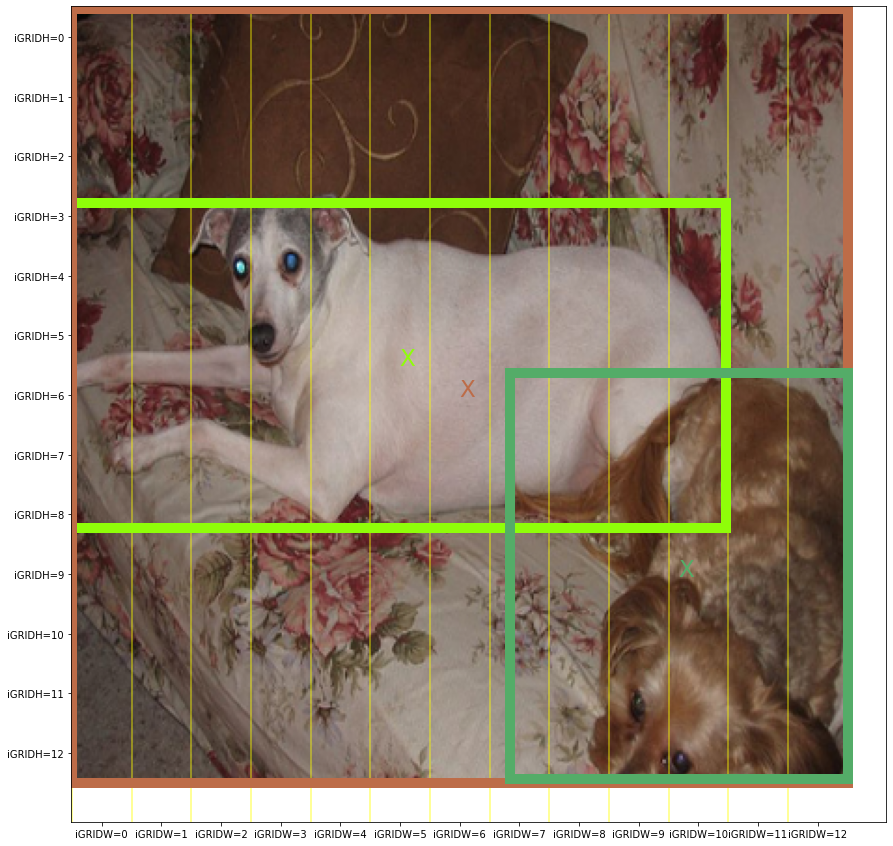

------------------------------
igrid_h=04,igrid_w=06,iAnchor=00, person


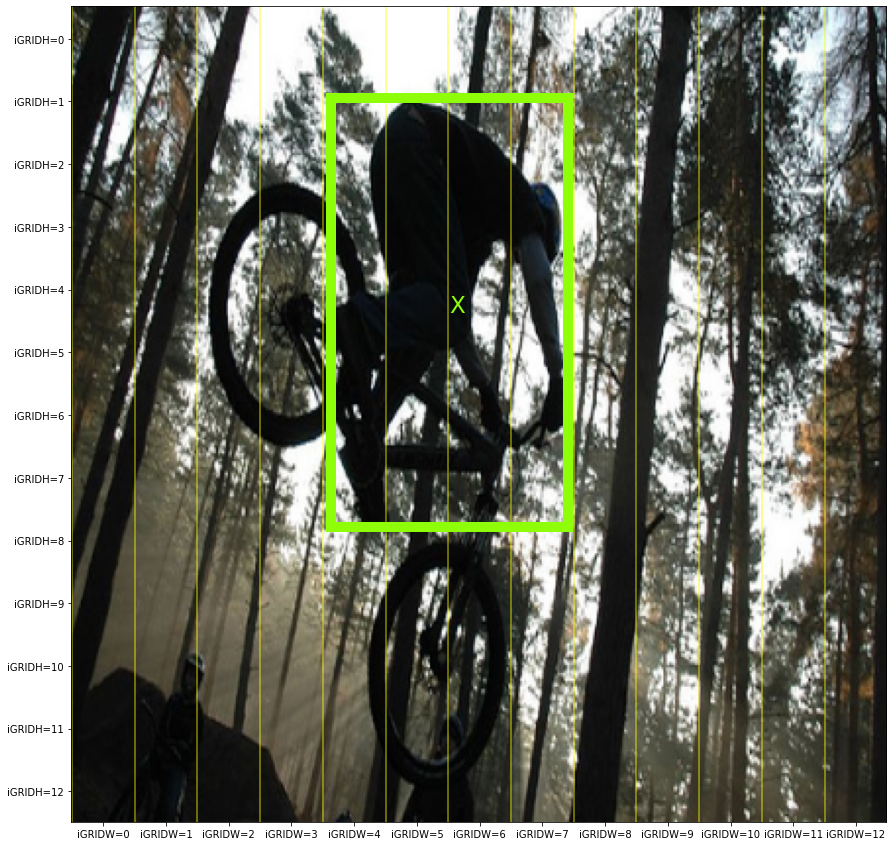

In [63]:
# sample usuage 
for irow in range(5, 10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()


In [70]:

'''Next, 
I am adding a function to prepare the input and the output. 
The input is a (448, 448, 3) image and 
the output is a (7, 7, 30) tensor. 
The output is based on S x S x (B * 5 +C).
'''
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow as tf

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)


In [65]:
'''https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html'''
input_image = Input(shape=(IMAGE_H,IMAGE_W,3))
true_boxes = Input(shape=(1,1,1,TRUE_BOX_BUFFER,4))


# building model 

In [79]:
# # layer1
# x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
# x = BatchNormalization(name='norm_1')(x)
# x = LeakyReLU(alpha=0.1)(x)
# x = MaxPooling2D(pool_size=(2,2),strides=2)(x)

# # layer2
# x = Conv2D(filters=64,kernel_size=3,strides=1,padding='same',name='conv_2',use_bias=False)(x)
# x = BatchNormalization(name='norm_2')(x)
# x = LeakyReLU(alpha=0.1)(x)
# x = MaxPooling2D(pool_size=(2,2),strides=2)(x)

# # layer3
# x = Conv2D(filters=128,kernel_size=3,strides=1,padding='same',name='conv_3',use_bias=False)(x)
# x = BatchNormalization(name='norm_3')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer4
# x = Conv2D(filters=64,kernel_size=1,strides=1,padding='same',name='conv_4',use_bias=False)(x)
# x = BatchNormalization(name='norm_4')(x)
# x = LeakyReLU(alpha=0.1)(x)
# # layer5 
# x = Conv2D(filters=128,kernel_size=3,strides=1,padding='same',name='conv_5',use_bias=False)(x)
# x = BatchNormalization(name='norm_5')(x)
# x = LeakyReLU(alpha=0.1)(x)
# x = MaxPooling2D(pool_size=(2,2),strides=2)(x)

# # layer6 
# x = Conv2D(filters=256,kernel_size=3,strides=1,padding='same',name='conv_6',use_bias=False)(x)
# x = BatchNormalization(name='norm_6')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer7
# x = Conv2D(filters = 128,kernel_size=1,strides=1,padding='same',name='conv_7',use_bias=False)(x)
# x = BatchNormalization(name='norm_7')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer8
# x = Conv2D(filters=256,kernel_size=3,strides=1,padding='same',name='conv_8',use_bias=False)(x)
# x = BatchNormalization(name='norm_8')(x)
# x = LeakyReLU(alpha=0.1)(x)
# x = MaxPooling2D(pool_size=(2,2))(x)

# # layer9
# x = Conv2D(filters=512,kernel_size=3,strides=1,padding='same',name='conv_9',use_bias=False)(x)
# x = BatchNormalization(name='norm_9')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer10
# x = Conv2D(filters = 256,kernel_size=1,strides=1,padding='same',name='conv_10',use_bias=False)(x)
# x = BatchNormalization(name='norm_10')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer11
# x = Conv2D(filters=512,kernel_size=3,strides=1,padding='same',name='conv_11',use_bias=False)(x)
# x = BatchNormalization(name='norm_11')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer12 
# x = Conv2D(filters = 256,kernel_size=1,strides=1,padding='same',name='conv_12',use_bias=False)(x)
# x = BatchNormalization(name='norm_12')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer13 
# x = Conv2D(filters = 512,kernel_size=3,strides=1,padding='same',name='conv_13',use_bias=False)(x)
# x = BatchNormalization(name='norm_13')(x)
# x = LeakyReLU(alpha=0.1)(x)
# skip_connection = x 
# x = MaxPooling2D(pool_size=(2,2),strides=2)(x)

# # layer14 
# x = Conv2D(filters=1024,kernel_size=3,strides=1,padding='same',name='conv_14',use_bias=False)(x)
# x = BatchNormalization(name='norm_14')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer15 
# x = Conv2D(filters = 512,kernel_size=1,strides=1,padding='same',name='conv_15',use_bias=False)(x)
# x = BatchNormalization(name='norm_15')(x)
# x = LeakyReLU(alpha=0.1)(x)
# # layer16 
# x = Conv2D(filters=1024,kernel_size=3,strides=1,padding='same',name='conv_16',use_bias=False)(x)
# x = BatchNormalization(name='norm_16')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer17
# x = Conv2D(filters = 512,kernel_size=1,strides=1,padding='same',name='conv_17',use_bias=False)(x)
# x = BatchNormalization(name='norm_17')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer18
# x = Conv2D(filters = 1024,kernel_size=3,strides=1,padding='same',name='conv_18',use_bias=False)(x)
# x = BatchNormalization(name='norm_18')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer19 
# x = Conv2D(filters = 1024,kernel_size=1,strides=1,padding='same',name='conv_19',use_bias=False)(x)
# x = BatchNormalization(name='norm_19')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer20
# x = Conv2D(filters = 1024,kernel_size=3,strides=1,padding='same',name='conv_20',use_bias=False)(x)
# x = BatchNormalization(name='norm_20')(x)
# x = LeakyReLU(alpha=0.1)(x)

# # layer21
# skip_connection= Conv2D(64,(1,1),strides=1,padding='same',name='conv_21',use_bias=False)(skip_connection)
# skip_connection = BatchNormalization(name='norm_21')(skip_connection)
# skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
# skip_connection = Lambda(space_to_depth_x2)(skip_connection)


# x = concatenate([skip_connection,x])
# # layer22 
# x = Conv2D(1024,(3,3),strides=1,padding='same',name='conv_22',use_bias=False)(x)
# x = BatchNormalization(name='norm_22')(x)
# x = LeakyReLU(alpha=0.1)(x)
# # layer23 
# # Layer 23
# x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
# output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# # small hack to allow true_boxes to be registered when keras buil the model
# ouput = Lambda(lambda args:args[0])([output,true_boxes])

# model = Model([input_image,true_boxes],output)
# model.summary()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow as tf

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 416, 416, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 416, 416, 32  128         ['conv_1[0][0]']                 
                                )                                                           

In [73]:
!wget https://pjreddie.com/media/files/yolov2.weights

--2023-02-02 04:57:40--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  92.7MB/s    in 2.1s    

2023-02-02 04:57:43 (92.7 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [74]:
path_to_weight = './yolov2.weights'
class WeightReader:
    def __init__(self,weight_file):
        self.offset = 4 
        self.all_weights = np.fromfile(weight_file,dtype='float32')

    def read_bytes(self,size):
        self.offset = self.offset + size 
        return self.all_weights[self.offset-size:self.offset]

    def reset(self):
        self.offset =4 

reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(reader.all_weights.shape))


all_weights.shape = (50983565,)


In [81]:
reader.reset()
nb_conv = 23
for i in range(1,nb_conv+1):
    conv_layer = model.get_layer('conv_'+str(i))
    if i<nb_conv:
        norm_layer = model.get_layer('norm_'+str(i))
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta = reader.read_bytes(size)
        gamma = reader.read_bytes(size)
        mean =  reader.read_bytes(size)
        var =  reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma,beta,mean,var])
    
    if len(conv_layer.get_weights())>1:
        bias = reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel,bias])
    else:
        kernel = reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

layer = model.layers[-4]#the last convolutional layer
weights = layer.get_weights()
new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel,new_bias])


In [82]:
'''Define a custom learning rate scheduler'''
from tensorflow import keras 
class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self,schedule):
        super(CustomLearningRateScheduler,self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self,epoch,logs=None):
        if not hasattr(self.model.optimizers,"lr"):
            raise ValueError("optimizers must have lr attributes")
        # get the current learning rate from model's optimizer 
        lr = float(tf.keras.backend.get_value(self.model.optimizers.learning_rate))
        # call schedule function to get the scheduled learning rate 
        scheduled_lr = self.schedule(epoch,lr)
        # set the value back to the optimizer before this epoch starts 
        tf.keras.backend.set_value(self.model.optimizers.lr,scheduled_lr)
        print("\nEpoch:%0.5d:Learning rate is %6.4f."%(epoch,scheduled_lr))


In [83]:
LR_SCHEDULE = [
# epch to start,learning rate tuples
    (0,0.01),
    (75,0.001),
    (105,0.0001),
]
def lr_schedule(epoch,lr):
    '''Helper function to retrieve the schduled learning rate based on epoch'''
    if epoch<LR_SCHEDULE[0][0] or epoch>LR[-1][0]:
        return lr 
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr 

'''Define the loss function'''
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [91]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX):
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    ---output---
    for any i=0,1...,batch size -1 

    '''
    cell_x = tf.cast(tf.reshape(tf.tile(
        tf.range(GRID_W),[GRID_H]),
        (1,GRID_H,GRID_W,1,1)),
        tf.float32 
    )
    # cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    
    cell_y = tf.transpose(cell_x,(0,2,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_x,cell_y],-1),[BATCH_SIZE,1,1,BOX,1])
    return (cell_grid)


def adjust_scale_prediction(y_pred,cell_grid,ANCHORS):
    '''Adjust prediction
    ===input===
    y_pred: takes many real values tensor or shape = (N batch ,N Grid w,NAnchor ,4+1+N class)
    ANCHORS:list containing width and height specialization fo anchor box 
    ===output===

    pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
    
    pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] = center_X
    pred_box_xy[irow,igrid_h,igrid_w,ianchoe,1] = center_1 
    
    Calculation process:
    tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1 
    tf.sigmoid(y_pred[...,:2]) + cell_grid: 
            takes values between 0 and grid_W - 1 for x coordinate 
            takes values between 0 and grid_H - 1 for y coordinate 
    
    '''
    BOX = int(len(ANCHORS)/2)
    # adjust x and y 
    pred_box_xy = tf.sigmoid(y_pred[...,:2])+cell_grid # bx,by 

    # adjust w and h 
    pred_box_wh = tf.sigmoid(y_pred[...,2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2])

    # adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[...,4]) # prob bb 

    # adjust class probabilities 
    pred_box_class = y_pred[...,5:] # prC1,prC2,
    return (pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)


def print_min_max(vec,title):
    try:
        print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))
    except ValueError as e :  #raised if `y` is empty.
        print(e)



In [92]:

GRID_W = 13 
GRID_H = 13 
BOX  = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size = BATCH_SIZE*GRID_W*GRID_H*BOX*(4+1+CLASS)
y_pred = np.random.normal(size=size,scale=10/(GRID_H*GRID_W))
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4+1+CLASS)
y_pred_tf = tf.constant(y_pred,dtype="float32")

cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
(pred_box_xy,   pred_box_wh, pred_box_conf, pred_box_class) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)


In [98]:
'''extract the groun truth'''
def extract_ground_truth(y_true):
    true_box_xy = y_true[...,0:2]
    true_box_wh = y_true[...,2:4]
    true_box_conf = y_true[...,4]
    true_box_class = tf.argmax(y_true[...,5:],-1)
    return (true_box_xy,true_box_wh,true_box_conf,true_box_class)

y_batch_tf = tf.constant(y_batch,dtype='float32')
(true_box_xy,true_box_wh,true_box_conf,true_box_class) = extract_ground_truth(y_batch_tf)

def cal_loss_xywh(true_box_conf,COORD_SCALE,true_box_xy,pred_box_xy,true_box_wh,pred_box_wh):
    coord_mask = tf.expand_dims(true_box_conf,axis=-1)*LAMBDA_COORD
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask>0.0,tf.float32))
    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.

    return (loss_xy + loss_wh, coord_mask)

LAMBDA_COORD = 1
loss_xywh, coord_mask  = cal_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy,true_box_wh, pred_box_wh)


In [104]:
def cal_loss_class(true_box_conf,CLASS_SCALE,true_box_class,pred_box_class):
    '''
    ==input==
    true_box_conf:  tensor or shape (N,N,N,N)
    true_box_class:  tensor or shape (N,N,N,N) containing class index
    pred_box_class:  tensor or shape (N,N,N,N,N)
    CLASS_SCALE: 1.0 

    ==output==
    class_mask
    if object exists in this (grid_cell,anchor)pair and class object receive nonzero weights
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else:
        0  
    '''
    class_mask = true_box_conf * CLASS_SCALE 
    nb_class_box = tf.reduce_sum(tf.cast(class_mask >0.0 ,tf.float32))
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=true_box_class,
        logits = pred_box_class
        )
    loss_class = tf.reduce_sum(loss_class *class_mask)/(nb_class_box+1e-6)
    return (loss_class)

LAMBDA_CLASS   = 1
loss_class  = cal_loss_class(true_box_conf,LAMBDA_CLASS,
                                 true_box_class,pred_box_class)
print("*"*30 + "\nouput\n" + "*"*30) 
print("loss_class = {:4.3f}".format(loss_class))


******************************
ouput
******************************
loss_class = 2.995


In [108]:
def get_intersect_area(true_xy,true_wh,pred_xy,pred_wh):
    '''
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
        
    '''
    true_wh_half = true_wh/2 
    true_mins = true_xy - true_wh_half 
    true_maxes = true_xy + true_wh_half

    pred_wh_half = pred_wh/2. 
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    intersect_mins = tf.maximum(pred_mins,true_mins)
    intersect_maxes = tf.minimum(pred_maxes,true_maxes)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins,0.)
    intersect_area = intersect_wh[...,0]*intersect_wh[...,1]
    true_areas = true_wh[...,0]*true_wh[...,1]
    pred_areas = pred_wh[...,0]*pred_wh[...,1]

    union_areas = pred_areas + true_areas - intersect_area
    iou_scores = tf.truediv(intersect_area,union_areas)
    return (iou_scores)

def cal_IOU_pred_true_assigned(true_box_conf,true_box_xy,true_box_wh,pred_box_xy,pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    iou_scores = get_intersect_area(true_box_xy,true_box_wh,pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return (true_box_conf_IOU)

true_box_conf_IOU = cal_IOU_pred_true_assigned(
                            true_box_conf,
                            true_box_xy, true_box_wh,
                            pred_box_xy,  pred_box_wh)




In [111]:

def cal_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[...,0:2]
    true_wh = true_boxes[...,2:4]

    pred_xy = tf.expand_dims(pred_box_xy,4)
    pred_wh = tf.expand_dims(pred_box_wh,4)

    iou_scores = get_intersect_area(true_xy,true_wh,pred_xy,pred_wh)
    best_ious = tf.reduce_max(iou_scores,axis=4)
    return (best_ious)

true_boxes = tf.constant(b_batch,dtype="float32")
best_ious = cal_IOU_pred_true_best(pred_box_xy,
                                       pred_box_wh,
                                       true_boxes)

def get_conf_mask(best_ious,true_box_conf,true_box_conf_IOU,LAMBDA_NO_OBJECT,LAMBDA_OBJECT):
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair   

    '''
    conf_mask = tf.cast(best_ious<0.6,tf.float32) *(1-true_box_conf)*LAMBDA_NO_OBJECT
    conf_mask = conf_mask+true_box_conf_IOU * LAMBDA_OBJECT
    return (conf_mask)

conf_mask = get_conf_mask(best_ious, 
                             true_box_conf, 
                             true_box_conf_IOU,
                             LAMBDA_NO_OBJECT, 
                             LAMBDA_OBJECT)


In [113]:
def cal_loss_conf(conf_mask,true_box_conf_IOU,pred_box_conf):
    '''
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    nb_conf_box = tf.reduce_sum(tf.cast(conf_mask > 0.0,tf.float32))
    loss_conf = tf.reduce_sum(tf.square(true_box_conf_IOU - pred_box_conf)*conf_mask)
    return (loss_conf)

loss_conf = cal_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)


In [116]:
def custome_loss(y_true,y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0
        
    '''
    total_recall = tf.Variable(0.)
    # step 1 : Adjust prediction output 
    cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy ,pred_box_wh,pred_box_conf ,pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)

    # step 2 : Extract ground truth output 
    true_box_xy,true_box_wh,true_box_conf,true_box_class = extract_ground_truth(y_true)
    
    # step 3: Calculate loss for the bouding box parameters 
    loss_xywh,coord_mask = cal_loss_xywh(true_box_conf,LAMBDA_COORD,true_box_xy,pred_box_xy,true_box_wh,pred_box_wh)

    # step 4 : Calculate loss for the class probabilities 
    loss_class = cal_loss_class(true_box_conf,LAMBDA_CLASS,true_box_class,pred_box_class)

    # step 5 : For each (grid cell,anchor) pair:
    #   calculate the IoU between predicted and ground truth bounding box 

    true_box_conf_IOU = cal_IOU_pred_true_assigned(
        true_box_conf,
        true_box_xy,true_box_wh,
        pred_box_xy,pred_box_wh
    )
    # step 6 : For each predicted bound box from(grid cell,anchor box)
    #   calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = cal_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)

    # step 7 : For each grid cell,calculate the L_{i,j} ^{noobj}
    conf_mask = get_conf_mask(best_ious,true_box_conf,true_box_conf_IOU,LAMBDA_NO_OBJECT,LAMBDA_OBJECT)

    # step 8 : Calculate loss for the confidence 
    loss_conf = cal_loss_conf(conf_mask,true_box_conf_IOU,pred_box_conf)

    loss = loss_xywh + loss_conf + loss_class
    return loss 

true_boxes = tf.Variable(np.zeros_like(b_batch),dtype='float32')
loss = custome_loss(y_batch.astype('float32'),y_pred.astype('float32'))


In [117]:
'''Add a callback f
or saving the weights 
> Conpile the moedl''' 
from tensorflow import keras 
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import SGD,Adam,RMSprop

dir_log = 'logs/'
try:
    os.makedirs(dir_log)
except Exception as e :
    print(e)

In [119]:
generator_config['BATCH_SIZE'] = BATCH_SIZE
early_stop = EarlyStopping(
    monitor='loss',
    min_delta = 0.001,
    patience=3,
    mode='min',
    verbose=1)

checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/cv_data/yolo_v2/weights_yolo_on_voc2012.h5', 
    monitor = 'loss',
    verbose=1,
    save_best_only = True,
    mode = 'min', 
    period = 1
    )

optimizer = Adam(lr=0.5e-4,beta_1=0.9,beta_2 = 0.999,epsilon=1e-08,decay=0.0)
model.compile(loss=custome_loss,optimizer=optimizer)




In [125]:
# tf.config.experimental_run_functions_eagerly(True)

history = model.fit_generator(          
    train_batch_generator, 
    steps_per_epoch  = len(train_batch_generator), 
    epochs           = 50, 
    verbose          = 1,
    callbacks        = [early_stop, checkpoint], 
    max_queue_size   = 3
)

<ipython-input-125-842471e9ff7a>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


NotImplementedError: ignored